In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from glob import glob

import ruptures as rpt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tnrange, tqdm_notebook

from utils.custom_cost import CostNew

# 1 Data importing

TE Process

In [2]:
files = sorted(glob('TEP_data/*_te.dat'))

In [3]:
columns=[]
for i in range(1,42):
    columns.append("XMEAS({})".format(i))
for i in range(1,12):
    columns.append("XMV({})".format(i))

In [4]:
# We do not use the first file because it does not contain a defect
test = {}
for i,j in enumerate(files[1:],start=1):
    test[i] = pd.read_table(j, sep="\s+", names=columns)

# 2 Testing ensembling functions

In [6]:
signal = StandardScaler().fit_transform(test[1].values)

## 2.1 Testing Dynp and DynpEnsembling algorithms

In [7]:
print('Dynp algorithm:')
algo = rpt.Dynp(custom_cost='l1', jump=1).fit(signal)

my_bkps = algo.predict(n_bkps=1)
print(f'Detection delay = {(my_bkps[0]-160)*3} min')

Dynp algorithm:
Detection delay = 153 min


In [8]:
print('DynpEnsembling algorithm:')
c = CostNew()
algo = rpt.DynpEnsembling(custom_cost=c, jump=1, ensembling=5).fit(signal)

my_bkps = algo.predict(n_bkps=1)
print(f'Detection delay = {(my_bkps[0]-160)*3} min')

DynpEnsembling algorithm:
Detection delay = 30 min


## 2.2 Testing Window and WindowEnsembling algorithms

In [22]:
print('Window algorithm:')
algo = rpt.Window(custom_cost='ar', jump=1, width=40).fit(signal)

my_bkps = algo.predict(n_bkps=1)
print(f'Detection delay = {(my_bkps[0]-160)*3} min')

Window algorithm:
Detection delay = -216 min


In [63]:
print('WindowEnsembling algorithm:')
c = CostNew()
algo = rpt.WindowEnsembling(custom_cost=c, jump=1, width=40, ensembling=5).fit(signal)

my_bkps = algo.predict(n_bkps=1)
print(f'Detection delay = {(my_bkps[0]-160)*3} min')

WindowEnsembling algorithm:
Detection delay = 42 min


## 2.3 Testing BinSeg and BinSegEnsembling algorithms

In [61]:
print('BinSeg algorithm:')
algo = rpt.Binseg(custom_cost='l2', jump=1).fit(signal)

my_bkps = algo.predict(n_bkps=1)
print(f'Detection delay = {(my_bkps[0]-160)*3} min')

BinSeg algorithm:
Detection delay = 153 min


In [62]:
print('BinSegEnsembling algorithm:')
c = CostNew()
algo = rpt.BinsegEnsembling(custom_cost=c, jump=1, ensembling=5).fit(signal)

my_bkps = algo.predict(n_bkps=1)
print(f'Detection delay = {(my_bkps[0]-160)*3} min')

BinSegEnsembling algorithm:
Detection delay = 24 min


# 3 Dynp experiment

## 3.1 Individual algorithms

In [7]:
def dynp(cost, data, params):
    ttf = []
    for i in data.keys():
        stsc = StandardScaler()
        signal = stsc.fit_transform(data[i])
        algo = rpt.Dynp(model=cost, 
                        params=params, 
                        jump=1)
        algo.fit(signal)

        my_bkps = algo.predict(n_bkps=1)
        ttf.append(my_bkps[0]-160)
    return pd.DataFrame({(cost+' '+str(*params.values())): ttf}).T

In [8]:
models = (
    {'cost':'ar', 'params':{'order':1}},
    {'cost':'mahalanobis', 'params':{}},
    {'cost':'l1', 'params':{}},
    {'cost':'l2', 'params':{}},
    {'cost':'linear', 'params':{}},
#     {'model':'rbf', 'params':{}},
)

In [9]:
table = []
for model in tqdm_notebook(models):
    results = dynp(data=test, **model)
    table.append(results)

In [10]:
(pd.concat(table)*3).style.background_gradient(cmap='Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ar 1,168,321,-240,0,321,357,243,2040,2304,1260,870,2199,1539,2265,2220,1755,93,696,2070,219,1665
mahalanobis,30,90,-24,0,6,0,0,1740,1164,1971,864,1095,1305,2076,2109,1512,102,810,1983,252,1476
l1,72,258,-240,0,186,228,6,2265,2307,2010,1344,2316,1761,2298,2226,1971,60,672,2064,2244,1668
l2,153,324,-240,0,174,246,96,2121,1116,1983,1350,2313,1323,2298,2226,1968,60,672,2070,2232,1668
linear,2229,957,2094,624,1635,0,2193,2247,1791,540,609,1719,1941,501,2154,1920,2235,621,594,414,2247


In [11]:
final_table = (pd.concat(table)*3)

pd.DataFrame({'FDR, %':(final_table[(final_table>=0) & (final_table<96)].count(axis=1) / 21 * 100).round(1),
              'ADD (detected)':final_table[(final_table>=0) & (final_table<96)].mean(axis=1).round(1),
              'ADD (all)':final_table[final_table>=0].mean(axis=1).round(1)}).style.background_gradient(cmap='Blues')

,"FDR, %",ADD (detected),ADD (all)
ar 1,9.5,46.5,1130.2
mahalanobis,28.6,21,929.2
l1,19,34.5,1297.8
l2,9.5,30,1219.6
linear,4.8,0,1393.6


## 3.2 Ensemble

In [15]:
def dynpEnsemble(cost, data, num_agg_func):
    ttf = []
    for i in data.keys():
        stsc = StandardScaler()
        signal = stsc.fit_transform(data[i].values)
        algo = rpt.DynpEnsembling(custom_cost=cost, 
                                  jump=1, 
                                  ensembling=num_agg_func)
        algo.fit(signal)

        my_bkps = algo.predict(n_bkps=1)
        ttf.append(my_bkps[0]-160)
    return pd.DataFrame({(num_agg_func): ttf}).T

In [16]:
%%time
cost = CostNew()
table1 = []

for n in tnrange(1,7, desc='agg functions loop'):
    table1.append(dynpEnsemble(cost=cost, data=test, num_agg_func=n))


CPU times: user 28min 27s, sys: 13.1 s, total: 28min 40s
Wall time: 4min 47s


In [17]:
(pd.concat(table1)*3).style.background_gradient(cmap='Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,153,318,-240,0,177,357,252,2121,1116,1266,1344,1095,1350,2292,2226,1968,60,696,2058,222,1530
2,153,318,-240,0,177,357,252,2121,1116,1266,1344,1095,1350,2292,2226,1968,60,696,2058,222,1530
3,30,258,-240,0,42,0,6,192,1116,1260,456,1095,1308,2265,1689,579,57,672,2058,219,1530
4,168,318,-240,0,51,0,243,2121,1116,1272,456,1095,1356,2292,2226,585,60,696,2067,255,1530
5,168,318,-240,0,51,0,243,2121,1116,1272,456,1095,1356,2292,2226,585,60,696,2067,255,1530
6,168,318,-240,0,42,0,243,2040,1122,1275,870,1095,1356,2298,2133,579,93,672,2070,369,1530


In [18]:
final_table = (pd.concat(table1)*3)

pd.DataFrame({'FDR, %':(final_table[(final_table>=0) & (final_table<96)].count(axis=1) / 21 * 100).round(1),
              'ADD (detected)':final_table[(final_table>=0) & (final_table<96)].mean(axis=1).round(1),
              'ADD (all)':final_table[final_table>=0].mean(axis=1).round(1)}).style.background_gradient(cmap='Blues')

,"FDR, %",ADD (detected),ADD (all)
1,9.5,30,1030
2,9.5,30,1030
3,28.6,22.5,741.6
4,19,27.8,895.4
5,19,27.8,895.4
6,19,33.8,913.6


# 4 Win experiment

## 4.1 Individual algorithms

In [25]:
models = (
    {'cost':'ar', 'params':{'order':1}, 'width':10},
    {'cost':'ar', 'params':{'order':1}, 'width':40},
#     {'cost':'ar', 'params':{'order':5}, 'width':100},
    {'cost':'mahalanobis', 'params':{}, 'width':10},
    {'cost':'mahalanobis', 'params':{}, 'width':40},
#     {'cost':'mahalanobis', 'params':{}, 'width':100},
    {'cost':'l1', 'params':{}, 'width':10},
    {'cost':'l1', 'params':{}, 'width':40},
#     {'cost':'l1', 'params':{}, 'width':100},
    {'cost':'l2', 'params':{}, 'width':10},
    {'cost':'l2', 'params':{}, 'width':40},
#     {'cost':'l2', 'params':{}, 'width':100},
#     {'cost':'linear', 'params':{}, 'width':10},
#     {'cost':'linear', 'params':{}, 'width':40},
#     {'cost':'linear', 'params':{}, 'width':100}
#     {'model':'rbf', 'params':{}, 'width':40},
#     {'model':'rbf', 'params':{}, 'width':100},
)

In [26]:
def wind(cost, data, params, width):
    ttf = []
    for i in data.keys():
        stsc = StandardScaler()
        signal = stsc.fit_transform(data[i].values)
        algo = rpt.Window(model=cost, 
                          params=params, 
                          width=width, 
                          jump=1)
        algo.fit(signal)

        my_bkps = algo.predict(n_bkps=1)
        ttf.append(my_bkps[0]-160)
    return pd.DataFrame({(cost+' '+str(*params.values()), width): ttf}).T

In [27]:
table = []
for model in tqdm_notebook(models, desc='agg functions loop'):
    table.append(wind(**model, data=test))

In [28]:
(pd.concat(table)*3).style.background_gradient(cmap='Blues')

In [29]:
final_table = (pd.concat(table)*3)

pd.DataFrame({'FDR, %':(final_table[(final_table>=0) & (final_table<96)].count(axis=1) / 21 * 100).round(1),
              'ADD (detected)':final_table[(final_table>=0) & (final_table<96)].mean(axis=1).round(1),
              'ADD (all)':final_table[final_table>=0].mean(axis=1).round(1)}).style.background_gradient(cmap='Blues')

## 4.2 Ensemble

In [30]:
def windowEnsemble(cost, data, num_agg_func, width):
    ttf = []
    for i in data.keys():
        stsc = StandardScaler()
        signal = stsc.fit_transform(data[i].values)
        algo = rpt.WindowEnsembling(custom_cost=cost, 
                                    jump=1, 
                                    ensembling=num_agg_func, 
                                    width=width)
        algo.fit(signal)

        my_bkps = algo.predict(n_bkps=1)
        ttf.append(my_bkps[0]-160)
    return pd.DataFrame({(num_agg_func, width): ttf}).T

In [42]:
%%time
cost = CostNew()
table1 = []

for n in tnrange(1,7, desc='agg functions loop'):
    for w in tqdm_notebook([10, 40], desc='width loop', leave=False):
        table1.append(windowEnsemble(cost=cost, data=test, num_agg_func=n, width=w))

In [32]:
(pd.concat(table1)*3).style.background_gradient(cmap='Blues')

In [33]:
final_table = (pd.concat(table1)*3)

pd.DataFrame({'FDR, %':(final_table[(final_table>=0) & (final_table<96)].count(axis=1) / 21 * 100).round(1),
              'ADD (detected)':final_table[(final_table>=0) & (final_table<96)].mean(axis=1).round(1),
              'ADD (all)':final_table[final_table>=0].mean(axis=1).round(1)}).style.background_gradient(cmap='Blues')

# 5 BinSeg experiment

## 5.1 Individual algorithms

In [34]:
models = (
    {'cost':'ar', 'params':{'order':1}},
    {'cost':'mahalanobis', 'params':{}},
    {'cost':'l1', 'params':{}},
    {'cost':'l2', 'params':{}},
    {'cost':'linear', 'params':{}},
#     {'model':'rbf', 'params':{}},
)

In [35]:
def binseg(cost, data, params):
    ttf = []
    for i in data.keys():
        stsc = StandardScaler()
        signal = stsc.fit_transform(data[i].values)
        algo = rpt.Binseg(model=cost, 
                          params=params, 
                          jump=1)
        algo.fit(signal)

        my_bkps = algo.predict(n_bkps=1)
        ttf.append(my_bkps[0]-160)
    return pd.DataFrame({(cost+' '+str(*params.values())): ttf}).T

In [36]:
table = []
for model in tqdm_notebook(models, desc='agg functions loop'):
    table.append(binseg(**model, data=test))

In [37]:
(pd.concat(table)*3).style.background_gradient(cmap='Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
ar 1,168,321,-240,0,321,357,243,2040,2304,1260,870,2199,1539,2265,2220,1755,93,696,2070,219,1665
mahalanobis,30,90,-24,0,6,0,0,1740,1164,1971,864,1095,1305,2076,2109,1512,102,810,1983,252,1476
l1,72,258,-240,0,186,228,6,2265,2307,2010,1344,2316,1761,2298,2226,1971,60,672,2064,2244,1668
l2,153,324,-240,0,174,246,96,2121,1116,1983,1350,2313,1323,2298,2226,1968,60,672,2070,2232,1668
linear,2229,957,2094,624,1635,0,2193,2247,1791,540,609,1719,1941,501,2154,1920,2235,621,594,414,2247


In [38]:
final_table = (pd.concat(table)*3)

pd.DataFrame({'FDR, %':(final_table[(final_table>=0) & (final_table<96)].count(axis=1) / 21 * 100).round(1),
              'ADD (detected)':final_table[(final_table>=0) & (final_table<96)].mean(axis=1).round(1),
              'ADD (all)':final_table[final_table>=0].mean(axis=1).round(1)}).style.background_gradient(cmap='Blues')

,"FDR, %",ADD (detected),ADD (all)
ar 1,9.5,46.5,1130.2
mahalanobis,28.6,21,929.2
l1,19,34.5,1297.8
l2,9.5,30,1219.6
linear,4.8,0,1393.6


## 5.2 Ensemble

In [5]:
def binsegEnsemble(cost, data, num_agg_func):
    ttf = []
    for i in data.keys():
        stsc = StandardScaler()
        signal = stsc.fit_transform(data[i].values)
        algo = rpt.BinsegEnsembling(custom_cost=cost, 
                                    jump=1, 
                                    ensembling=num_agg_func)
        algo.fit(signal)

        my_bkps = algo.predict(n_bkps=1)
        ttf.append(my_bkps[0]-160)
    return pd.DataFrame({(num_agg_func): ttf}).T

In [6]:
cost = CostNew()
table1 = []

for n in tnrange(1,7, desc='agg functions loop'):
    table1.append(binsegEnsemble(cost, data=test, num_agg_func=n))

In [7]:
(pd.concat(table1)*3).style.background_gradient(cmap='Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,153,318,-240,0,177,357,252,2121,1116,1266,1344,1095,1350,2292,2226,1968,60,696,2058,222,1530
2,153,318,-240,0,177,357,252,2121,1116,1266,1344,1095,1350,2292,2226,1968,60,696,2058,222,1530
3,30,258,-240,0,42,0,6,192,1116,1260,456,1095,1308,2265,1689,579,57,672,2058,219,1530
4,-462,2382,-462,-462,-459,2382,2379,-462,-462,-459,-462,-459,-456,-462,-462,-462,-462,2382,-462,-462,-462
5,-462,2382,-462,-462,-459,2382,2379,-462,-462,-459,-462,-459,-456,-462,-462,-462,-462,2382,-462,-462,-462
6,2382,2382,-462,-462,-462,2382,-462,-462,-462,-459,-462,-462,-462,-462,-462,-462,-462,2382,-462,-462,-462


In [8]:
final_table = (pd.concat(table1)*3)

pd.DataFrame({'FDR, %':(final_table[(final_table>=0) & (final_table<96)].count(axis=1) / 21 * 100).round(1),
              'ADD (detected)':final_table[(final_table>=0) & (final_table<96)].mean(axis=1).round(1),
              'ADD (all)':final_table[final_table>=0].mean(axis=1).round(1)}).style.background_gradient(cmap='Blues')

,"FDR, %",ADD (detected),ADD (all)
1,9.5,30,1030
2,9.5,30,1030
3,28.6,22.5,741.6
4,0,nan,2381.2
5,0,nan,2381.2
6,0,nan,2382


In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [ ]:
# import matplotlib.pyplot as plt
# for i in test[1].columns:
#     test[1][i].plot(figsize=(12,6), label='data example')
#     plt.axvline(160, color='green', linewidth=3, label='changepoint')
#     plt.axvspan(160, 256, alpha=0.08, color='green', label='detection window (10% of a total length)')
# #     plt.grid()
#     plt.legend()
#     plt.xlabel('Point number (1 point=3 min)')
#     plt.ylabel('Data values')
#     plt.tight_layout()
#     plt.show()

In [12]:
def scaling1(array):
    return (array - np.max(array,axis=0)) / (np.max(array,axis=0) - np.min(array,axis=0))

In [30]:
def scaling2(array):
    return ((array+1) / np.min(array+1,axis=0)) - np.max(((array+1) / np.min(array+1,axis=0)),axis=0)

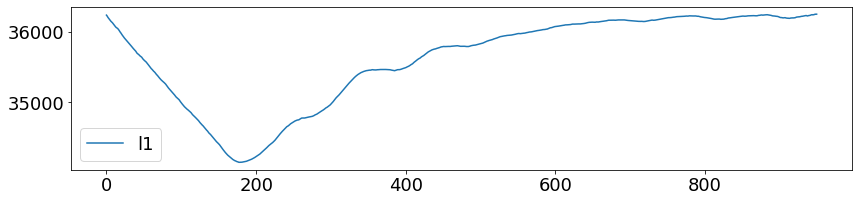

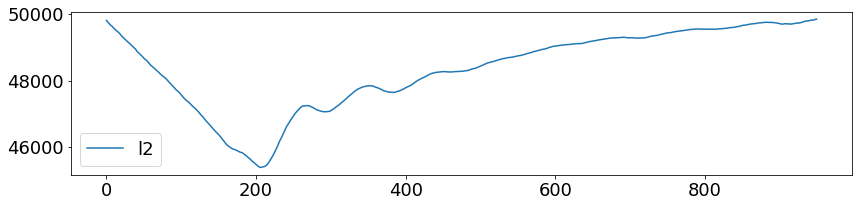

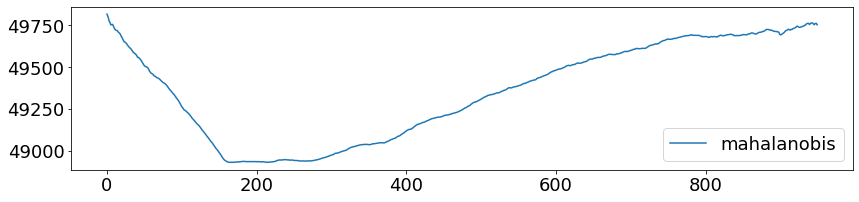

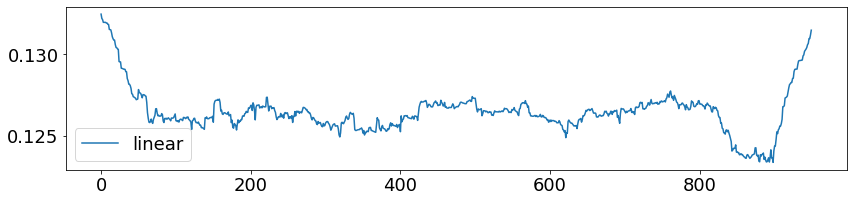

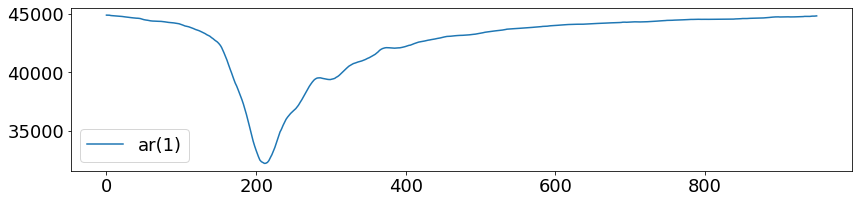

In [41]:
stsc = StandardScaler()
signal = stsc.fit_transform(test[1].values)

n = len(signal)

all_results = []
for cost in [rpt.costs.CostL1(),rpt.costs.CostL2(),rpt.costs.CostMl(),rpt.costs.CostLinear(),rpt.costs.CostAR(order=1)]:
    c = cost.fit(signal)
    t = []
    for i in range(5, len(signal)-5):
        t.append(c.sum_of_costs([i, n]))
    all_results.append(t)

all_results = np.array(all_results).T

for i, name in enumerate(['l1','l2','mahalanobis','linear','ar(1)']):
    plt.figure(figsize=(14,3))
    plt.plot(all_results[:,i])
    plt.legend([name])
    plt.show()

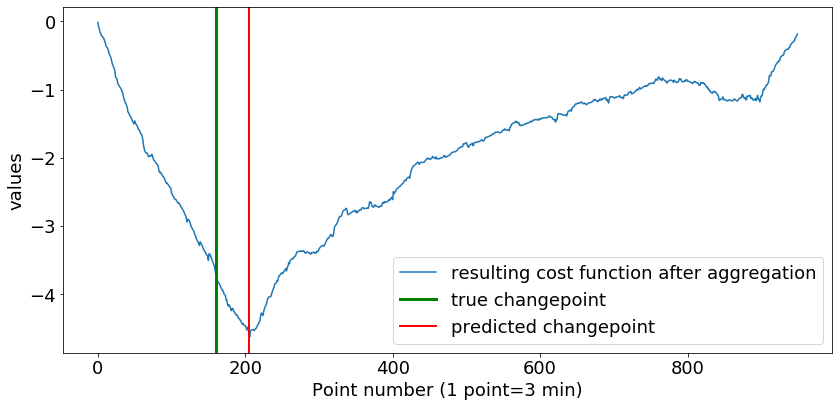

In [35]:
plt.figure(figsize=(12,6))
plt.plot(np.sum(scaling1(all_results),axis=1),label='resulting cost function after aggregation')
plt.axvline(160, color='green', linewidth=3, label='true changepoint')
plt.axvline(205, color='red', linewidth=2, label='predicted changepoint')
plt.legend()
plt.xlabel('Point number (1 point=3 min)')
plt.ylabel('values')
plt.tight_layout()
plt.show()